# Skip-gram model to obtain context-free word embeddings

<a target="_blank" href="https://colab.research.google.com/github/jaspock/me/blob/main/docs/materials/transformers/assets/notebooks/skipgram.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Code written by Juan Antonio Pérez in 2024. Originally inspired on the Tae Hwan Jung's code (@graykode) at the [NLP tutorial](https://github.com/graykode/nlp-tutorial).

This notebook presents the implementation of a skip-gram model to obtain non-contextual word embeddings       . The conceptual framework that we need to implement this model is so similar to the one used in the notebooks implementing logistic and softmax regressors that most of your effort will be spent in understanding the process of obtaining the data or representing the embeddings, more than in PyTorch code itself. As you will see, the skip-gram model is a particular case of a logistic regressor where the output is the probability of a word being a context word of another word, that is, the probability of two words being close neighbors in a text.

Our softmax regressor dealing with topic classification required each input sentence to be encoded as an embedding vector. As it was too early to talk about embeddings, we used a library (`sentence-transformers`) to obtain them in a black-box fashion. Here we will see how to get an embedding for every word in a text, not for every sentence. However, it turns out that, although there exist more elaborated methods to obtain sentence embeddings, one the simplest ones is to average the embeddings of the words in the sentence. Consequently, this notebook could also be easily adapted to implement a very rudimentary version of the `sentence-transformers` library.

**Question**: Integrate this code and the code of the softmax regressor to have a self-contained version of the sentence topic classifier that does not depend on external libraries.

In [66]:
!pip install torch matplotlib

In [67]:
import torch
import random

torch.random.manual_seed(22)
random.seed(22)

## Data preprocessing

We start with the code that obtains the data that will be later packed into mini-batches. Following the algorithm, each mini-batch contains positive and negative samples in a 1:$k$ ratio. To obatin the positive samples, we iterate over the corpus word by word. For each *target* word, we obtain the context words within a window of size $L$. As allowing different values of $L$ would slightly complicate the implementation, we simply set $L=1$ and consider only the *context* words before and after the target word. To obtain the negative samples, we combine the target word and sample noise words from the vocabulary. The Martin and Jurafsky's book explains that these noise words are chosen based on their unigram frequency, but we will also simplify here and choose them uniformly at random.

We usually use a large text file to train the skip-gram model. For the sake of simplicity, we use a toy dataset stored in a single string in which each sentence contains a few words and two noticeable domains, namely, fruits and animals, can be found. Sometimes, a word of one of the domains occurs in the context of a sentence of the other domain.

Observe how the period at the end of each sentence is considered as a word. Separating the period from the last word of the sentence, we make sure that "uva" and "uva." are not considered as different words. We also lowercase all the words to avoid having different embeddings for the same word in different cases ("Manzana" and "manzana", for example). Although this preprocessing was frequent in the past, it is not common anymore in current real-world applications due to the large scale of the datasets and training procedures. This is a first example of how we will not process only words; actually, the more general word *token* will be used to refer to the atomic elements of the vocabulary. As we will see, tokens can be words, but also subwords, characters, punctuation marks, emojis, or even the bytes which make up the different characters.

In [75]:
corpus = """
    perro gato ratón pájaro .
    manzana naranja pera uva .
    azul rojo verde amarillo .
    guitarra piano violín flauta .
    perro gato .
    uva pera manzana .
    amarillo rojo .
    piano violín .
    ratón pájaro gato .
    verde azul amarillo uva .
    perro .
    naranja .
    azul piano verde .
    flauta guitarra .
    gato ratón perro .
    manzana naranja uva pera .
    rojo amarillo azul .
    violín piano flauta .
    pájaro ratón gato perro .
    uva manzana naranja .
    verde azul .
    guitarra violín piano .
    perro pájaro .
    pera uva manzana naranja .
    amarillo verde rojo azul .
    flauta piano .
    gato ratón pájaro .
    naranja uva manzana pera .
    azul rojo verde .
    violín flauta guitarra piano .
"""

The following lines are common boilerplate code to obtain the vocabulary in the form of word-to-index and index-to-word dictionaries. Note that our corpus is first transformed into a list of words. Also note that we keep the whole corpus in memory, which is not a problem for this toy dataset but would be for a large corpus.

In [76]:
corpus = corpus.split()  # split by space
word_list = list(set(corpus))  # removes duplicates
word_dict = {w: i for i, w in enumerate(word_list)}  # word from index
dict_word = {i: w for i, w in enumerate(word_list)}  # index from word
voc_size = len(word_list)  # number of words

print(f"word_dict = {word_dict}")
print(f"dict_word = {dict_word}")
print(f"voc_size = {voc_size}")

word_dict = {'naranja': 0, 'violín': 1, 'azul': 2, 'rojo': 3, 'gato': 4, '.': 5, 'piano': 6, 'guitarra': 7, 'uva': 8, 'flauta': 9, 'perro': 10, 'pera': 11, 'pájaro': 12, 'ratón': 13, 'verde': 14, 'amarillo': 15, 'manzana': 16}
dict_word = {0: 'naranja', 1: 'violín', 2: 'azul', 3: 'rojo', 4: 'gato', 5: '.', 6: 'piano', 7: 'guitarra', 8: 'uva', 9: 'flauta', 10: 'perro', 11: 'pera', 12: 'pájaro', 13: 'ratón', 14: 'verde', 15: 'amarillo', 16: 'manzana'}
voc_size = 17


We create now two lists, one for the positive samples and one for the negative samples. Each list item contains the index of the target word and the index of the context word or the noise word, respectively. Recall that our context window for positive samples will be of size 1 and that we will use a 1:$k$ ratio between positive and negative samples.

We iterate over the corpus word by word starting at index 1 and ending at index `len(corpus)-1` to avoid considering the first and last words of the corpus as target words, as this would require special treatment due to the lack of context words before and after them, respectively.

It is not strictly necessary at this point to create $k$ times more negative samples than positive samples, as the value of $k$ in the algorithm determines the ratio of negative samples in each mini-batch. However, it makes sense to create more negative samples than positive samples to avoid having to repeat a reduced set of negative samples over and over again in the mini-batches.

**Documentation:** [random.sample](https://docs.python.org/3/library/random.html#random.sample)

**Question:** Adapt the code so that different window sizes can be used.

In [77]:
k = 2  # ratio of negative samples to positive samples

skip_grams_positive = []
for i in range(1, len(corpus) - 1):
    target = word_dict[corpus[i]]
    context = [word_dict[corpus[i - 1]], word_dict[corpus[i + 1]]]
    for c in context:
        skip_grams_positive.append([target, c])

skip_grams_negative = []
for i in range(len(corpus)):
    target = word_dict[corpus[i]]
    context = [word_dict[i] for i in random.sample(word_list,k)]
    for c in context:
        skip_grams_negative.append([target, c])

print(f"Some positive samples: {skip_grams_positive[:3]}")
print(f"Some negative samples: {skip_grams_negative[:3]}")
print(f"Some positive samples with tokens: {', '.join([f'({dict_word[i[0]]},{dict_word[i[1]]})' for i in skip_grams_positive[:3]])}")
print(f"Some negative samples with tokens: {', '.join([f'({dict_word[i[0]]},{dict_word[i[1]]})' for i in skip_grams_negative[:3]])}")

Some positive samples: [[4, 10], [4, 13], [13, 4]]
Some negative samples: [[10, 11], [10, 1], [4, 14]]
Some positive samples with tokens: (gato,perro), (gato,ratón), (ratón,gato)
Some negative samples with tokens: (perro,pera), (perro,violín), (gato,verde)


## Mini-batch generation

It's time to define the function that returns a mini-batch of positive and negative samples. The function receives as input the `skip_grams_positive` and `skip_grams_negative` lists and the size of the mini-batch. It returns a tuple containing the indices of the target words, the indices of the context/noise words and the labels of the samples. The labels are 1 for positive samples and 0 for negative samples.

In [78]:
import numpy as np

def random_batch(skip_grams_positive, skip_grams_negative, batch_size):
    random_target = []
    random_context= []
    random_output = []

    positive_size = batch_size//(k+1)

    random_index = np.random.choice(range(len(skip_grams_positive)), positive_size, replace=True)
    for i in random_index:
        random_target.append(skip_grams_positive[i][0])
        random_context.append(skip_grams_positive[i][1])
        random_output.append(1)  # desired output = 1

    random_index = np.random.choice(range(len(skip_grams_negative)), positive_size*k, replace=True)
    for i in random_index:
        random_target.append(skip_grams_negative[i][0])
        random_context.append(skip_grams_negative[i][1])
        random_output.append(0)  # desired output = 0 

    return random_target, random_context, random_output


## Model definition

We have already implemented some PyTorch models by now, so you should be familiar with the basic ideas of the following code. There are, however, some new additions.

The `Word2Vec` class extends PyTorch's `nn.Module`. The constructor method `__init__` is responsible for initializing the model's layers and other components. In this class, two embedding layers are created and randomly initialized: `self.W` and `self.C`. Both are instances of PyTorch's `nn.Embedding` class, which is used to store word embeddings. The `nn.Embedding` layer is a lookup table that maps the index of a word to its embedding vector. The embedding vectors are the parameters of the layer and are updated during training. The `nn.Embedding` layer is a particular case of the `nn.Linear` layer, which we have already used. As most of the functions in PyTorch, `nn.Embedding` expects a mini-batch of word indices as input and not a single word index. It then returns a mini-batch of embedding vectors. The `voc_size` parameter specifies the size of the vocabulary, whereas the `embedding_size` parameter sets the size of each embedding vector. In essence, `self.W` serves as the embedding matrix for target words, while `self.C` is for context words in the training data.

The `forward` method defines the computation performed at every call of the model. It takes two arguments, `Xt` and `Xc`, which are the input tensors for target words and context/noise words, both of size `(batch_size, 1)`. The method uses the embedding layers to transform these input word indices into dense embedding vectors.

### Einstein summation notation

The most critical operation is `torch.einsum` which we describe next. You may find from time to time that some operations that you would like to perform are not available in PyTorch. In these cases, you can use `torch.einsum` to perform tensor operations with Einstein summation notation. This function is a powerful tool that allows for concise and efficient computation of complex tensor algebra.

Let's consider the case where we have a mini-batch of target words represented by their embeddings $\mathbf{w}_1,\mathbf{w}_2,\ldots,\mathbf{w}_E$. For each of these target words, we have an associated contextual word in the set $\mathbf{c}_1,\mathbf{c}_2,\ldots,\mathbf{c}_E$. To simplify, let's not consider negative samples, but this analysis is fully extendable to the case where they are included.

Let $N$ be the size of the embeddings. We want to calculate the dot product of each $\mathbf{w}_i$ with its corresponding $\mathbf{c}_i$, a calculation fundamental in the training and use of skip-gram models. To obtain these dot products using PyTorch and benefit from the efficiency of matrix operations computed on GPUs, we can pack the embeddings of the target words by rows into a matrix $A$ of size $E \times N$ and the embeddings of the contextual words by columns into a matrix $B$ of size $N \times E$. By calculating the product $A \cdot B$, we will obtain a matrix of size $E \times E$ where each element $i,j$ is the dot product of $\mathbf{w}_i$ with $\mathbf{c}_j$. 

However, we are only interested in a small part of all these dot products. Specifically, those that form part of the diagonal of the result, which will be the ones of the form $\mathbf{w}_i$ $\mathbf{c}_i$. Matrix multiplication is very inefficient in this case for our purposes, but if we look in the PyTorch documentation, we will not initially find an operation that fits exactly to our interests.

There is, however, in PyTorch an efficient and compact way to define matrix operations based on Einstein's notation, which you can learn a little about by reading up to approximately section 2.8 of the tutorial "[Einsum is all you need](https://rockt.github.io/2018/04/30/einsum)". In particular, we can see that we are interested in obtaining a vector $\mathbf{d}$ such that:

$$
\mathbf{d}_i = \mathbf{w}_i \cdot \mathbf{c}_i = \sum_{j} \mathbf{w}_{i,j} \, \mathbf{c}_{j,i}
$$

Using Einstein's notation with PyTorch's `einsum` function, we can write the previous matrix operation and obtain the one-dimensional tensor we want as

    d = torch.einsum('ij,ji->i', A, B)

**Question:** Rewrite the Einstein notation in the code to avoid the transposition of the matrix $c$.

**TODO:** copy all discussions on Pytorch stuff from teacher's notes; add seeds in every notebook; use GPU if available in every notebook; difference between F.sigmoid and torch.sigmoid; move epoch to steps; move word_dict and dict_word to word_index and index_word; add model.train() and eval()

**Documentation:** [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), [torch.nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [torch.einsum](https://pytorch.org/docs/stable/generated/torch.einsum.html), [torch.sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html), [torch.t](https://pytorch.org/docs/stable/generated/torch.t.html)

In [79]:
import torch.nn as nn
import torch.nn.functional as F

# Model
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super().__init__()
        self.W = nn.Embedding(voc_size, embedding_size)  # target matrix 
        self.C = nn.Embedding(voc_size, embedding_size)  # context matrix

    def forward(self, Xt, Xc):
        w = self.W(Xt)  
        c = self.C(Xc)
        dot = torch.einsum('ij,ji->i',w,c.t())
        output_layer = F.sigmoid(dot)
        return output_layer

## Training the model

Training the model is straightforward given the code we have already seen in previous notebooks. We use the `Adam` optimizer and the `BCELoss` (binary cross-entropy) loss function. The main novelty is that the lists of indices returned by `random_batch` are converted into PyTorch tensors of long integers (`torch.long`) before being passed to the model. This is because PyTorch expects the indices of the embedding layer to be of this type. Note, however, that `BCELoss` expects the labels to be floating-point numbers (`torch.float32`). The remaining code is very similar to what we have seen before.

**Exercise:** Adapt the code to use the `SGD` optimizer instead of `Adam` and compare the results in 3 different training runs.

**Documentation:** [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), [torch.nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [torch.Tensor.to](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.to), [torch.optim.zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html), [torch.Tensor.backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html), [torch.optim.step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)

In [84]:

import torch.optim as optim

batch_size = 256
embedding_size = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Word2Vec(voc_size, embedding_size).to(device)

criterion = nn.BCELoss()
# model.parameters(): iterable with all parameters of the model
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training
for epoch in range(10000):
    input_w_batch, input_c_batch, target_batch = random_batch(skip_grams_positive, skip_grams_negative, batch_size)
    input_w_batch = torch.tensor(input_w_batch,dtype=torch.long).to(device)
    input_c_batch = torch.tensor(input_c_batch,dtype=torch.long).to(device)
    target_batch = torch.tensor(target_batch,dtype=torch.float32).to(device) 

    optimizer.zero_grad()
    output = model(input_w_batch,input_c_batch)

    # output : [batch_size], target_batch : [batch_size]
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch: {(epoch+1):04d}, cost={loss:.6f}')

    loss.backward()
    optimizer.step()


Epoch: 1000, cost=0.454811
Epoch: 2000, cost=0.468414
Epoch: 3000, cost=0.459508
Epoch: 4000, cost=0.432788
Epoch: 5000, cost=0.526175
Epoch: 6000, cost=0.445378
Epoch: 7000, cost=0.432225
Epoch: 8000, cost=0.432305
Epoch: 9000, cost=0.432573
Epoch: 10000, cost=0.433031


## Visualizing the embeddings

The parameters of the model are unpacked into tensors `W` and `C`. The `W` tensor contains the embeddings of the target words, whereas the `C` tensor contains the embeddings of the context words.

We will represent the embeddings of `W` in a two-dimensional space. To do so, the two dimensions of each embedding are unpacked into the `x` and `y` variables which are then plotted via `plt.scatter`. The `plt.annotate` function is used to add the word labels to the plot. Knowing most of the arguments of this function is out of the scope of this notebook, but you can find more information in the documentation.

**Exercise:** Adapt the code to plot the embeddings of `C` instead of `W`, as well as the average of the embeddings of `W` and `C`.

**Documentation:** [matplotlib.pyplot.scatter](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html), [matplotlib.pyplot.annotate](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

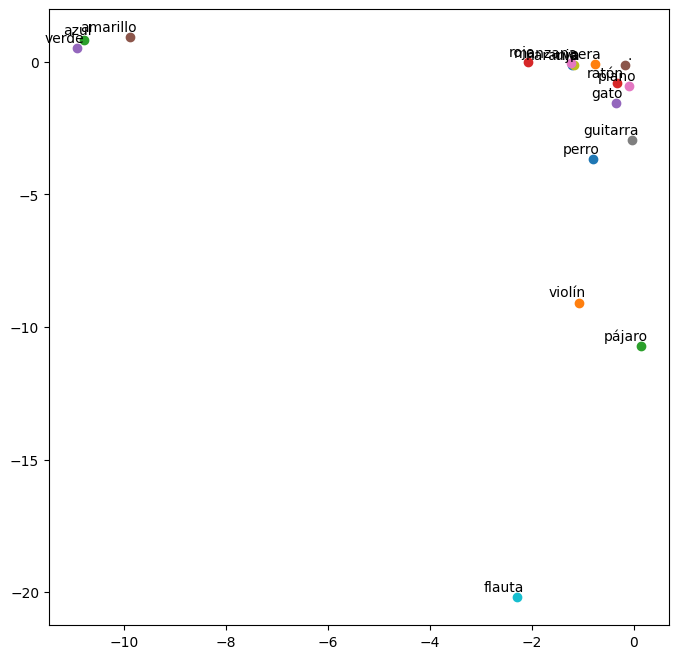

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))  # square figure
for i, label in enumerate(word_list):
    W, C = model.parameters()  # W, _ = model.parameters() would be more appropriate
    x, y = W[i][0].item(), W[i][1].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


## Computing the similarity between words

The resulting similarity between two words can be measured by the cosine similarity between their embeddings. See, for example, how the similarity between "uva" and "manzana" is higher than the similarity between "uva" and "gato".

In [ ]:
cos = nn.CosineSimilarity(dim=0) # works on dim=1 by default (a batch of tensors, but there is only dim=0 in our case)

print(f"Cosine similarity between 'uva' and 'manzana' is {cos(model.W[word_dict['uva']], model.W[word_dict['manzana']]).item():.3f}")
print(f"Cosine similarity between 'uva' and 'gato' is {cos(model.W[word_dict['uva']], model.W[word_dict['gato']]).item():.3f}")